# Geographic vs Projected CRS

You will learn about difference between these CRSs in more detail.

Each CRS is optimised ot best represent the:
- shape and/or
- scale/distnace and/or
- area

of features in a dataset. There is not a single CRS that does a great job at optimising all 3 elements: shape, distance AND area. Some CRSs are optimised for shape, some are optimised for distance and some are optimised for area. Some CRSs are also optimised for particular regions - for instance the US or EU.

## Intro to CRS

Geographic coordinate systems (which are often but not always in decimal degree units) are often optimal when you need to locate places on the Earth. Or when you need to create global maps. However, lat and long locations are not located using uniform measurement units. Thus, geographic CRSs are not ideal for measuring distance. This is why other projected CRS have been developed

![CRS](CRS.png)

## The structure of a geographic CRS

A geographic CRS uses a grid that wraps around the entire globe. This means that each point on the globe is defined using the SAME coordinate system and the same units as defined within that particular geographic CRS. Geographic CRS are best for global analysis however it is important to remember that distance is distorted using a geographic lat/long CRS

The geograhic WGS84 lat/long CRS has an origin - (0, 0) - located at the intersection of the Equator (0 latitude) and Prime Meridian (0 longitude) on the globe.

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import geopandas as gpd
from shapely.geometry import Point
import earthpy as et
import seaborn as sns

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set working dir & get data
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

![Globmap](Globmap.png)

* Data Note: The distance between the 2 degree of longitude at the equator (0 degree) is ~69 miles. The distance between 2 degrees of longitude at 40N (or S) is only 53 miles. This difference in actual distance relative to "distance" between the actual parallels and meridians demonstrates how distance calculations will be less accurate when using geographic CRSs

## Projected CRS

As you learned above, geographic coordinate systemse are ideal for creating global maps. However, they are prone to error when quantifying distance. In contrast, various spatial projections have evolved that can be used to more accurately capture distance, shape and/or area.

### What is a spatial projection

Spatial projection refers to the math calculations performed to flatten the 3D data onto a 2D plane. Projecting data from a round surface onto a flat surface, results in visual modifications to the data when plotted on a map. Some areas are stretched and some are compressed. You can see this distortion when you look at a map of the entire globe.

The math calculations used in spatial projections are designed to optimise the relative size and shape of a particular region on the globe.

![SpaProj](SpaProj.png)

### About UTM

The Universal Transverse Mercator (UTM) system is a commmonly used projected coordinate reference system. UTM subdivides the globe into zones, numbered 0-60 (equivalent to longitude) and regions (North and South)

* Data Note: UTM zones are also defined using bands, lettered C-X (equivalent to lat) however, the band designation is often dropped as it isn't essential to specifying the location.

While UTM zones span the entire globe, UTM uses a regional projection and associated coordinate system. The coordinate system grid for each zone is projected individually using the Mercator projection.

The origin (0, 0) for each UTM zone and associated region is located at the intersection of the equator and a location, 500,000 m east of the central meridian of each zone. The origin location is placed outside of the boundary of the UTM zone, to avoid negative Easting numbers.

![UTM](UTM.png)

![UTM Grid](UTMgrid.jpg)

### Understand UTM Coordinates

Compare coordinates for 1 location, but saved in 2 different CRSs to better understand what this looks like. The coordinates for Boulder, Colorado in UTM are:

UTM Zone 13N easting: 476,911.31m, northing: 4,429,455.35

Remember that N deontes that it is in the Northern hemisphere on Earth

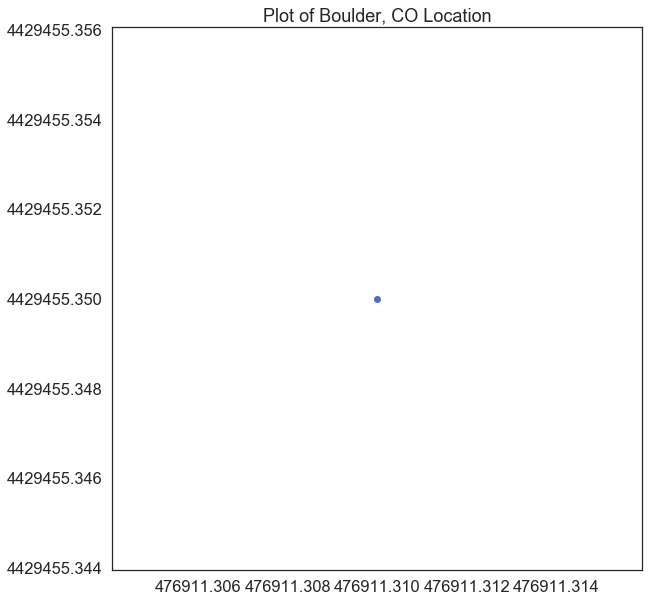

In [2]:
boulder_df = np.array([[476911.31, 4429455.35]])
geometry = [Point(xy) for xy in boulder_df]

boulder_loc = gpd.GeoDataFrame(geometry,
                              columns=["geometry"],
                              crs={"init": "epsg:2957"})

fig, ax = plt.subplots(figsize=(10, 10))
boulder_loc.plot(ax=ax)
ax.set_title("Plot of Boulder, CO Location")

# Turn off scientific notation
plt.ticklabel_format(useOffset=False)
plt.show()

In [3]:
# View CRS
boulder_loc.crs

{'init': 'epsg:2957'}

Note the projection of your data in UTM is EPSG code 2957

If you spatially project your data into a geographic CRS, notice how your new coordinates are different - yet they still represent the same location.

In [4]:
# Reproject the data to WGS84
boulder_df_geog = boulder_loc.to_crs(epsg=4326)
boulder_df_geog.crs

c:\programdata\miniconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:4326', 'no_defs': True}

In [5]:
# View the coordinate values of the newly reprojected data.
boulder_df_geog

,geometry
0,POINT (-105.27055 40.01498)


Now you can plot your data on top of your world map which is also in a geographic CRS.

In [6]:
# Import world boundary shapefile
worldBound_path = os.path.join("data", "spatial-vector-lidar", "global",
                              "ne_110m_land", "ne_110m_land.shp")

worldBound = gpd.read_file(worldBound_path)

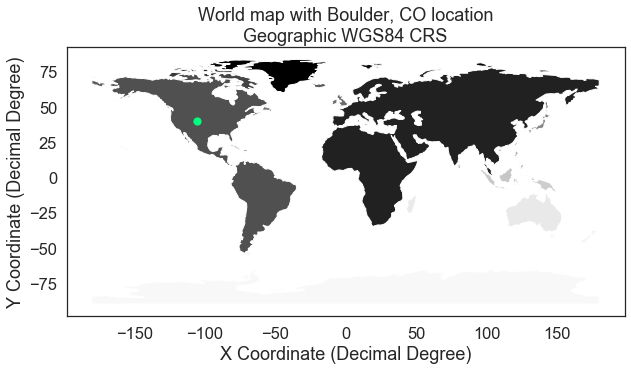

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

worldBound.plot(cmap="Greys",
               ax=ax)

ax.set(title="World map with Boulder, CO location\nGeographic WGS84 CRS",
      xlabel="X Coordinate (Decimal Degree)",
      ylabel="Y Coordinate (Decimal Degree)")

boulder_df_geog.plot(ax=ax,
                    markersize=52,
                    color="springgreen")

plt.show()

### Important Tips

While sometimes UTM zones in the North vs South are specified using N and S respectively (e.g. UTM Zone 18N) other times you may see a letter as follows: Zone 18T, 730782m Easting, 4712631m Northing vs UTM Zone 18N, 730782m, 4712631m.

* Data Tip: The UTM szstem doesn't apply to polar regions (>80 N or S). Universal Polar Stereographic (UPS) coordinate system is used in these area. THis is where zones A, B and Y, Z are used if zou were wondering why they weren't in the UTM lettering system.

### Datum

The datum describes the vertical and horizontal reference point of the coordinate system. The vertical datum describes the reationship between a specified ellipsoid (the top of the earth's surface) and the center of the earth. The datum also describes the origin (0,0) of a coordinate system.

Frequency encountered datums:
- WGS84 - World Geodetic System (created in) 1984. The origin is the center of the Earth.
- NAD27 & NAD83 - North American Datum 1927 & 1983, respectively.The origion for NAD 27 is Meades Ranch in Kansas.
- ED50 - European Datum 1950

All CRS have a vertical and horizontal datum which defines a "0, 0" reference point. There are 2 models used to define the datum: ellipsoid (or spheroid): A math representation of the shape of the Earth.

### CRS formats

There are numerous formats that are used to document a CRS. Next tutorial, you will discuss 3 of the commonly encountered formats including: Proj4, WKT, and EPSG.